In [8]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import torch.optim  as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy
import shap

from models.CNN_EEG import CNNEEG_32, restore_parameters, train_CNNEEG, evaluation_eegcnn
from utils import MakeDataset, generation_cnn_data, generation_cnn_noisedata, generation_cnn_con_data

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
eeg_col = ['EEG.Cz', 'EEG.Fz', 'EEG.Fp1',  'EEG.F7', 'EEG.F3', 'EEG.FC1', 'EEG.C3','EEG.FC5',
           'EEG.FT9', 'EEG.T7','EEG.CP5',  'EEG.CP1', 'EEG.P3', 'EEG.P7', 'EEG.PO9', 'EEG.O1',
           'EEG.Pz', 'EEG.Oz', 'EEG.O2', 'EEG.PO10', 'EEG.P8', 'EEG.P4', 'EEG.CP2', 'EEG.CP6',
            'EEG.T8', 'EEG.FT10', 'EEG.FC6', 'EEG.C4', 'EEG.FC2', 'EEG.F4', 'EEG.F8', 'EEG.Fp2']

In [10]:
path = './{}/base/{}.csv'
task = ['10','20','1back','3back']

# base dataset train

In [11]:
cyj_cnn_eeg_input, cyj_cnn_output = generation_cnn_data(path, 'shc', task, device)

10
20
1back
3back


In [12]:
print(cyj_cnn_eeg_input.size())
print(cyj_cnn_output.size())

torch.Size([2048, 32, 120])
torch.Size([2048])


In [13]:
dataset = MakeDataset(cyj_cnn_eeg_input, cyj_cnn_output)
train_dataset, test_dataset = random_split(dataset, [1536,512])
trainloader = DataLoader(train_dataset, 
                         batch_size=256, 
                         shuffle=True)

testloader = DataLoader(test_dataset,
                        batch_size = 256,
                        shuffle=True)


In [14]:
model = CNNEEG_32(32)
his = train_CNNEEG(model, trainloader, 1000, 0.0001, device= device)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 / 1000: Loss = 1.111
Epoch 2 / 1000: Loss = 1.106
Epoch 3 / 1000: Loss = 1.102
Epoch 4 / 1000: Loss = 1.098
Epoch 5 / 1000: Loss = 1.094
Epoch 6 / 1000: Loss = 1.091
Epoch 7 / 1000: Loss = 1.088
Epoch 8 / 1000: Loss = 1.084
Epoch 9 / 1000: Loss = 1.081
Epoch 10 / 1000: Loss = 1.078
Epoch 11 / 1000: Loss = 1.075
Epoch 12 / 1000: Loss = 1.072
Epoch 13 / 1000: Loss = 1.068
Epoch 14 / 1000: Loss = 1.065
Epoch 15 / 1000: Loss = 1.062
Epoch 16 / 1000: Loss = 1.059
Epoch 17 / 1000: Loss = 1.056
Epoch 18 / 1000: Loss = 1.053
Epoch 19 / 1000: Loss = 1.050
Epoch 20 / 1000: Loss = 1.047
Epoch 21 / 1000: Loss = 1.045
Epoch 22 / 1000: Loss = 1.042
Epoch 23 / 1000: Loss = 1.040
Epoch 24 / 1000: Loss = 1.037
Epoch 25 / 1000: Loss = 1.035
Epoch 26 / 1000: Loss = 1.032
Epoch 27 / 1000: Loss = 1.030
Epoch 28 / 1000: Loss = 1.027
Epoch 29 / 1000: Loss = 1.025
Epoch 30 / 1000: Loss = 1.023
Epoch 31 / 1000: Loss = 1.020
Epoch 32 / 1000: Loss = 1.018
Epoch 33 / 1000: Loss = 1.016
Epoch 34 / 1000: Lo

In [15]:
train_pred_list, train_target_list, test_pred_list, test_target_list = evaluation_eegcnn(model, trainloader, testloader, 256, device)

Train dataset loss : 0.8197008868058523
Train dataset acc :72.98177480697632%
Test dataset loss : 1.017867386341095
Test dataset acc :52.9296875%


In [16]:
explainer_shap = shap.DeepExplainer(model, cyj_cnn_eeg_input.float()[:100])
shap_values = explainer_shap.shap_values(cyj_cnn_eeg_input.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [17]:
for i in range(len(shap_values)):
    shap_values[i] = shap_values[i].reshape(100, 120, 32)

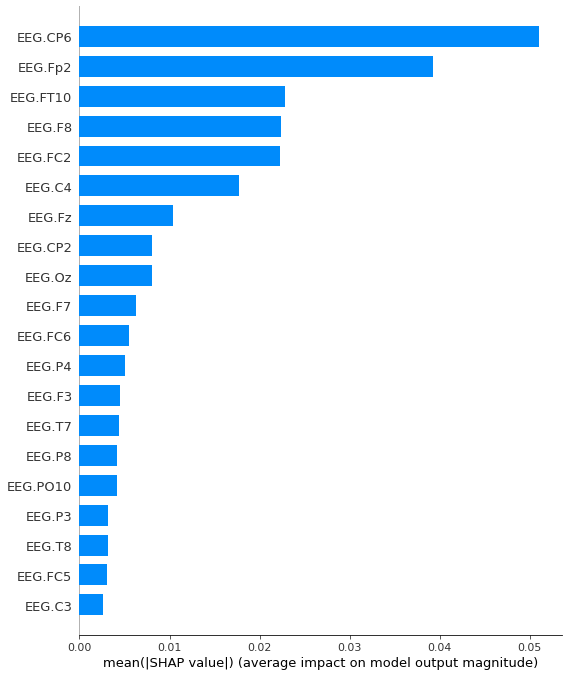

In [18]:
shap.summary_plot(shap_values[0][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

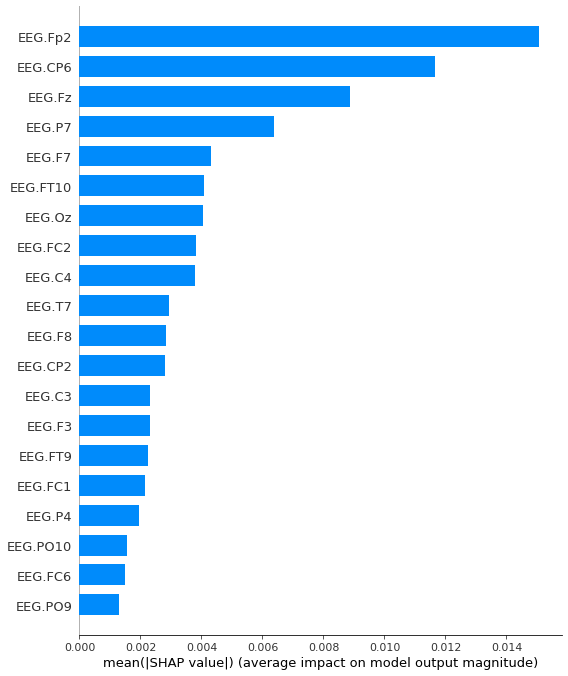

In [19]:
shap.summary_plot(shap_values[1][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

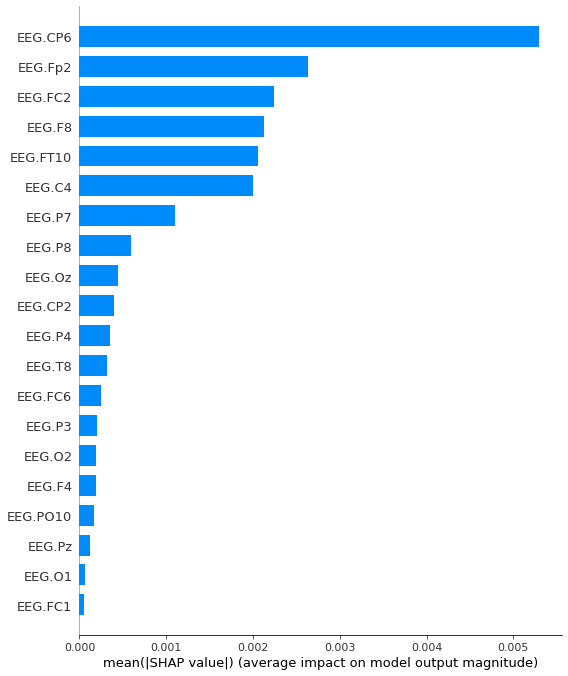

In [20]:
shap.summary_plot(shap_values[2][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

# noise-base model

In [21]:
path_list = ['./{}/base/{}.csv', './{}/noise/{}.csv']

In [22]:
cyy_eeg_input_con, output_con = generation_cnn_con_data(path_list, 'shc', task, device)

10
20
1back
3back
10
20
1back
3back


In [23]:
print(cyy_eeg_input_con.size())
print(output_con.size())

torch.Size([2048, 32, 120])
torch.Size([2048])


In [24]:
dataset_con = MakeDataset(cyy_eeg_input_con, output_con)
train_dataset_con, test_dataset_con = random_split(dataset_con, [1536,512])
trainloader_con = DataLoader(train_dataset_con, 
                         batch_size=256, 
                         shuffle=True)

testloader_con = DataLoader(test_dataset_con,
                        batch_size = 256,
                        shuffle=True)


In [25]:
model_con = CNNEEG_32(32)
his = train_CNNEEG(model_con, trainloader_con, 1000, 0.0001, device= device)

Epoch 1 / 1000: Loss = 1.113
Epoch 2 / 1000: Loss = 1.110
Epoch 3 / 1000: Loss = 1.107


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 4 / 1000: Loss = 1.103
Epoch 5 / 1000: Loss = 1.100
Epoch 6 / 1000: Loss = 1.096
Epoch 7 / 1000: Loss = 1.092
Epoch 8 / 1000: Loss = 1.089
Epoch 9 / 1000: Loss = 1.086
Epoch 10 / 1000: Loss = 1.083
Epoch 11 / 1000: Loss = 1.080
Epoch 12 / 1000: Loss = 1.077
Epoch 13 / 1000: Loss = 1.074
Epoch 14 / 1000: Loss = 1.071
Epoch 15 / 1000: Loss = 1.069
Epoch 16 / 1000: Loss = 1.066
Epoch 17 / 1000: Loss = 1.064
Epoch 18 / 1000: Loss = 1.061
Epoch 19 / 1000: Loss = 1.059
Epoch 20 / 1000: Loss = 1.056
Epoch 21 / 1000: Loss = 1.054
Epoch 22 / 1000: Loss = 1.052
Epoch 23 / 1000: Loss = 1.050
Epoch 24 / 1000: Loss = 1.048
Epoch 25 / 1000: Loss = 1.046
Epoch 26 / 1000: Loss = 1.044
Epoch 27 / 1000: Loss = 1.043
Epoch 28 / 1000: Loss = 1.041
Epoch 29 / 1000: Loss = 1.039
Epoch 30 / 1000: Loss = 1.038
Epoch 31 / 1000: Loss = 1.036
Epoch 32 / 1000: Loss = 1.035
Epoch 33 / 1000: Loss = 1.033
Epoch 34 / 1000: Loss = 1.032
Epoch 35 / 1000: Loss = 1.031
Epoch 36 / 1000: Loss = 1.030
Epoch 37 / 1000:

In [26]:
train_pred_list_con, train_target_list_con, test_pred_list_con, test_target_list_con = evaluation_eegcnn(model_con, trainloader_con, testloader_con, 256, device)

Train dataset loss : 0.8595241904258728
Train dataset acc :68.75%
Test dataset loss : 1.1279870867729187
Test dataset acc :41.9921875%


In [27]:
import shap

In [28]:
explainer_shap_con = shap.DeepExplainer(model_con, cyy_eeg_input_con.float()[:100])
shap_values_con = explainer_shap_con.shap_values(cyy_eeg_input_con.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [29]:
for i in range(len(shap_values_con)):
    shap_values_con[i] = shap_values_con[i].reshape(100, 120, 32)

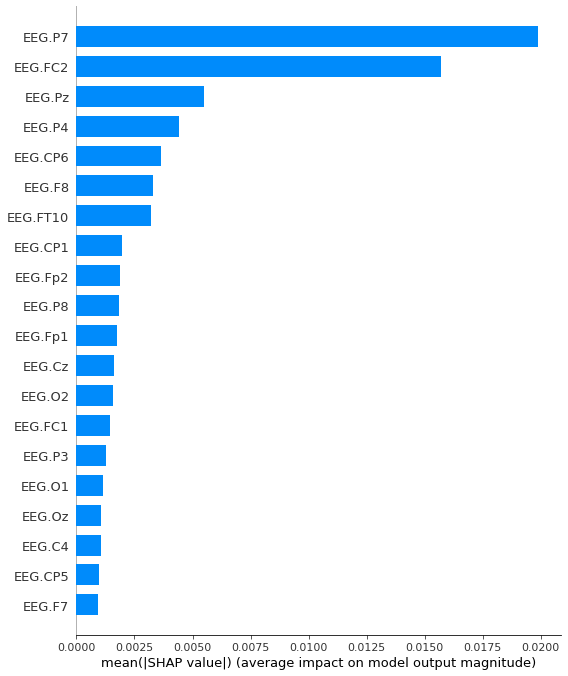

In [30]:
shap.summary_plot(shap_values_con[0][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

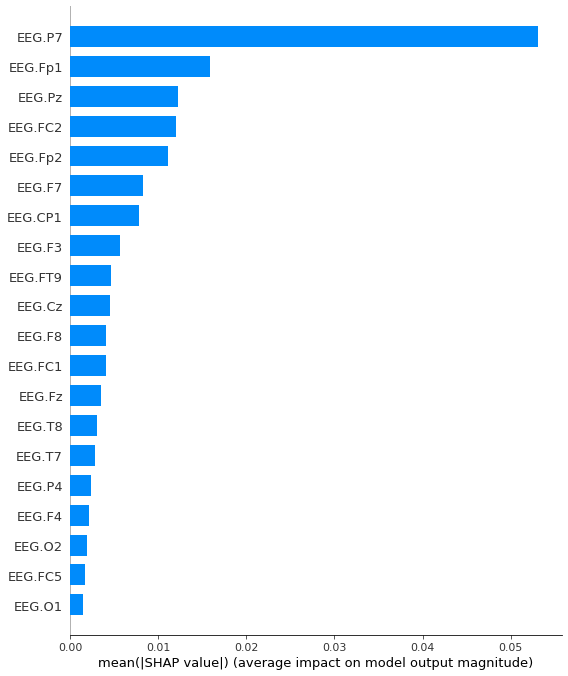

In [31]:
shap.summary_plot(shap_values_con[1][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

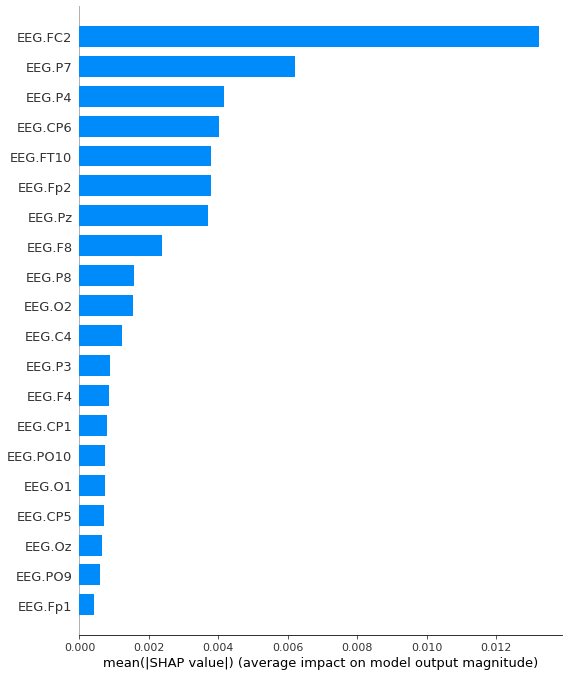

In [32]:
shap.summary_plot(shap_values_con[2][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

# noise CNN

In [33]:
eeg_input_noise, output_noise =  generation_cnn_noisedata('./{}/noise/{}.csv', 'shc', task, device)

10
20
1back
3back


In [34]:
print(eeg_input_noise.size())
print(output_noise.size())

dataset_noise = MakeDataset(eeg_input_noise, output_noise)
train_dataset_noise, test_dataset_noise = random_split(dataset_noise, [1536,512])
trainloader_noise = DataLoader(train_dataset_noise, 
                         batch_size=256, 
                         shuffle=True)

testloader_noise = DataLoader(test_dataset_noise,
                        batch_size = 256,
                        shuffle=True)


torch.Size([2048, 32, 120])
torch.Size([2048])


In [35]:
model_noise = CNNEEG_32(32)
his = train_CNNEEG(model_noise, trainloader_noise, 1000, 0.0001, device= device)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 / 1000: Loss = 1.100
Epoch 2 / 1000: Loss = 1.094
Epoch 3 / 1000: Loss = 1.089
Epoch 4 / 1000: Loss = 1.084
Epoch 5 / 1000: Loss = 1.079
Epoch 6 / 1000: Loss = 1.074
Epoch 7 / 1000: Loss = 1.069
Epoch 8 / 1000: Loss = 1.064
Epoch 9 / 1000: Loss = 1.060
Epoch 10 / 1000: Loss = 1.057
Epoch 11 / 1000: Loss = 1.054
Epoch 12 / 1000: Loss = 1.052
Epoch 13 / 1000: Loss = 1.049
Epoch 14 / 1000: Loss = 1.047
Epoch 15 / 1000: Loss = 1.044
Epoch 16 / 1000: Loss = 1.042
Epoch 17 / 1000: Loss = 1.039
Epoch 18 / 1000: Loss = 1.037
Epoch 19 / 1000: Loss = 1.034
Epoch 20 / 1000: Loss = 1.032
Epoch 21 / 1000: Loss = 1.030
Epoch 22 / 1000: Loss = 1.027
Epoch 23 / 1000: Loss = 1.025
Epoch 24 / 1000: Loss = 1.022
Epoch 25 / 1000: Loss = 1.020
Epoch 26 / 1000: Loss = 1.018
Epoch 27 / 1000: Loss = 1.015
Epoch 28 / 1000: Loss = 1.013
Epoch 29 / 1000: Loss = 1.010
Epoch 30 / 1000: Loss = 1.008
Epoch 31 / 1000: Loss = 1.006
Epoch 32 / 1000: Loss = 1.003
Epoch 33 / 1000: Loss = 1.001
Epoch 34 / 1000: Lo

In [36]:
trainnoise_pred_list, trainnoise_target_list, testnoise_pred_list, testnoise_target_list = evaluation_eegcnn(model_noise,
                                                                                                              trainloader_noise, testloader_noise, 256, device)

Train dataset loss : 0.8407034377257029
Train dataset acc :70.76823115348816%
Test dataset loss : 0.9854776561260223
Test dataset acc :56.25%


In [37]:
torch.argmax(model_noise(eeg_input_noise[:256].float()), dim = 1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [38]:
explainer_shap_noise = shap.DeepExplainer(model_noise, eeg_input_noise.float()[:100])
shap_values_noise = explainer_shap_noise.shap_values(eeg_input_noise.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [39]:
for i in range(len(shap_values_noise)):
    shap_values_noise[i] = shap_values_noise[i].reshape(100, 120, 32)

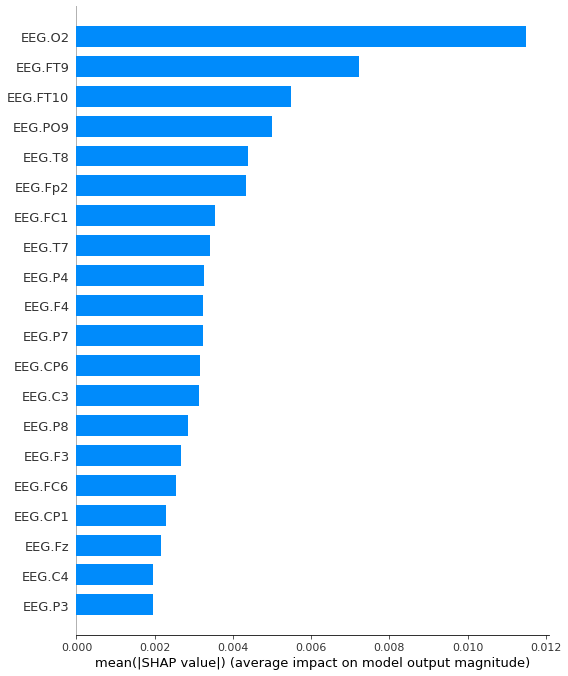

In [40]:
shap.summary_plot(shap_values_noise[0][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

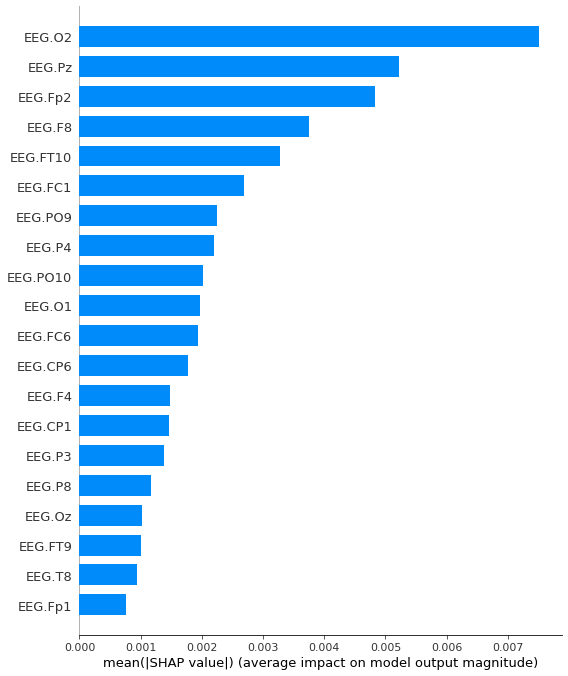

In [41]:
shap.summary_plot(shap_values_noise[1][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

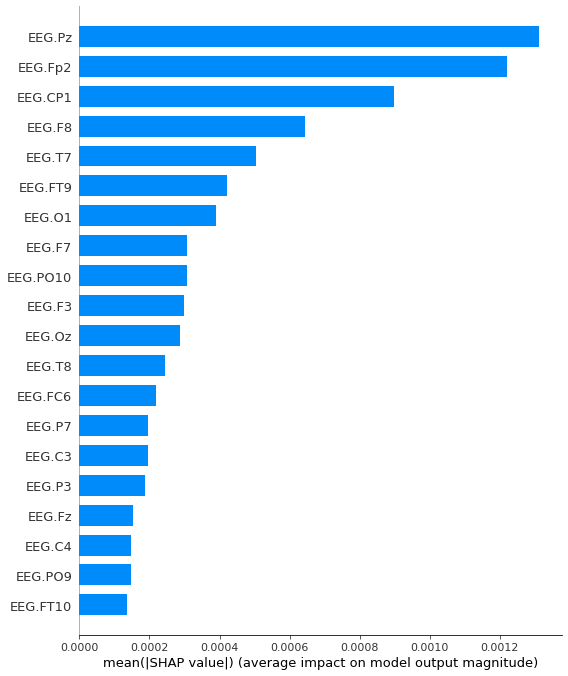

In [42]:
shap.summary_plot(shap_values_noise[2][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')